In [1]:
from fastai import *
from fastai.tabular import *
from fastai.tabular.data import *

In [2]:
import pandas as pd
from collections import Counter

In [3]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/NSLKDD/NSLKDD_Full.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DEI DATI***

In [4]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [5]:
dataset.head()

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,binlabel,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,anomaly,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,normal,normal


In [6]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder delle due variabili target, quindi da stringhe a interi sia in test che in train e salvo i valori nelle variabili y_test a y_train
# y_test viene utilizzata per la valutazione del modello

y_train_bin = LabelEncoder().fit_transform(train['binlabel'])
y_train = LabelEncoder().fit_transform(train['label'])
y_test_bin = LabelEncoder().fit_transform(test['binlabel'])
y_test = LabelEncoder().fit_transform(test['label'])

# tolgo la colonna 'binlabel' perché è una sotto variabile target 'label'
train = train.drop(['binlabel'], axis=1)
test = test.drop(['binlabel'], axis=1)

# sostituisco i valori originari con la codifica precedentemente fatta
target_index = train.columns.get_loc('label')
train.iloc[:, target_index] = y_train

# elimino la colonna relativa al target nel dataset di test poiché non utile
test = test.drop('label', axis=1)

In [25]:
train

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
13838,0,tcp,discard,RSTR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.00,1.00,0.00,0.00,255,1,0.00,0.05,0.04,0.0,0.00,0.0,0.04,1.00,15,1
133971,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108,10,0.0,0.0,1.0,1.00,0.09,0.08,0.00,255,10,0.04,0.06,0.00,0.0,0.00,0.0,1.00,1.00,21,0
49988,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.00,1.00,0.00,0.00,226,132,0.58,0.03,0.58,0.0,0.01,0.0,0.28,0.00,18,0
67701,0,udp,domain_u,SF,43,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,108,0.0,0.0,0.0,0.00,1.00,0.00,0.02,255,254,1.00,0.01,0.00,0.0,0.00,0.0,0.00,0.00,20,2
85473,0,tcp,netbios_dgm,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,156,5,1.0,1.0,0.0,0.00,0.03,0.09,0.00,255,5,0.02,0.08,0.00,0.0,1.00,1.0,0.00,0.00,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55646,0,tcp,http,SF,253,960,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,35,45,0.0,0.0,0.0,0.00,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,21,2
146152,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,9,0.0,0.0,1.0,1.00,0.09,0.06,0.00,255,9,0.04,0.05,0.00,0.0,0.00,0.0,1.00,1.00,21,0
114303,0,tcp,auth,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,238,6,1.0,1.0,0.0,0.00,0.03,0.06,0.00,255,6,0.02,0.07,0.00,0.0,1.00,1.0,0.00,0.00,20,0
15509,40423,tcp,private,RSTR,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,1.0,1.00,1.00,0.00,0.00,255,2,0.01,0.42,0.83,0.0,0.00,0.0,0.83,1.00,15,1


In [9]:
len(train)

74258

### ***MODEL***

In [10]:
""" Definisco delle variabili utili al nostro modello per saper come trattare i dati. 
  Distinguendo variabile target, continue e categoriali. 
  Inoltre in procs vengono passati degli ottimizzatori che vengono applicati ai dati prima del training: in particolare con FillMissing vengono sostituiti
  eventuali valori NaN, Categorify si occupa di codificare le variabili categoriali e Normalize si occupa di normalizzare i valori continui."""

dep_var = 'label'
cat_names = ["protocol_type", "service", "flag"]
cont_names = [col for col in train.columns if col not in cat_names]
cont_names.remove('label')
procs = [FillMissing, Categorify, Normalize]

In [11]:
# valid = 2500 righe
from sklearn.model_selection import train_test_split

def SplitSet(df):
     #train, test = train_test_split(df, test_size=0.1)
     train, valid = train_test_split(df, test_size=0.0336664)
     split_val = len(train)
     train = train.append(valid)
     #return train, test, split_val
     return train, split_val

traindf, idx = SplitSet(train)

In [12]:
# Lista da passare al nostro tabular learner per effettuare la fase di test
test = TabularList.from_df(test, cat_names= cat_names, cont_names=cont_names, procs=procs)

# Lista contenete gli insiemi di training e validation, necessari per l'addrestamento del modello
data = TabularList.from_df(traindf, cat_names= cat_names, cont_names=cont_names, procs=procs)
data = data.split_by_idx(list(range(idx, len(traindf))))
data = data.label_from_df(cols=dep_var)
data = data.add_test(test, label= 0)
data = data.databunch()

# Creazione del nostro modello con due Hidden layers da, rispettivamente, 200 e 100 neuroni.
# Per valutare la performance durante l'addestramento viene usata l'accuratezza
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, emb_drop=0.01, callback_fns=ShowGraph)

In [13]:
""" Visualizziamo la struttura del modello """
learn

Learner(data=TabularDataBunch;

Train: LabelList (71758 items)
x: TabularList
protocol_type tcp; service pop_3; flag SF; duration -0.1073; symbolic -0.0064; src_bytes 0.0092; dst_bytes -0.0158; DoS -0.0841; wrong_fragment -0.0091; urgent -0.0945; hot -0.0579; num_failed_logins 1.2137; logged_in -0.0093; num_compromised -0.0395; root_shell -0.0225; su_attempted -0.0098; num_root -0.0226; num_file_creations -0.0203; num_shells -0.0411; num_access_files 0.0000; num_outbound_cmds -0.0053; is_host_login -0.1124; is_guest_login -0.7048; count -0.3627; srv_count -0.5928; serror_rate -0.5877; srv_serror_rate -0.4055; rerror_rate -0.4045; srv_rerror_rate 0.7482; same_srv_rate -0.3483; diff_srv_rate -0.3766; srv_diff_host_rate -1.8562; dst_host_count -1.0658; dst_host_srv_count 1.0371; dst_host_same_srv_rate -0.4330; dst_host_diff_srv_rate 2.7666; dst_host_same_src_port_rate -0.2802; dst_host_srv_diff_host_rate -0.5958; dst_host_serror_rate -0.5829; dst_host_srv_serror_rate -0.4221; dst_host_rer

### ***TRAINING***

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


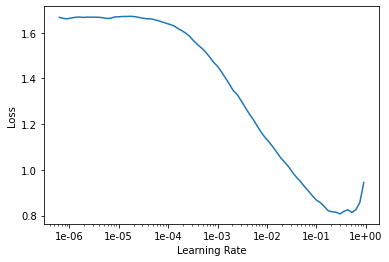

In [14]:
"""Troviamo il valore di learning rate da utilizzare per l'algoritmo di discesa del gradiente. 
  Prendiamo un valore mediano rispetto al punto di max pendenza """
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.054186,4.310395,0.977200,00:11
1,0.038946,5.436273,0.984000,00:11
2,0.026341,0.557774,0.987600,00:11
3,0.018357,1.125597,0.993600,00:11
4,0.012336,1.217005,0.994800,00:11


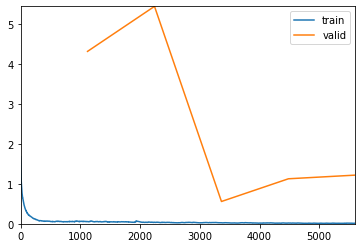

In [15]:
# Addestramento del modello
learn.fit_one_cycle(5, 1e-02, wd=0.02)

### ***PREDICTION***

In [16]:
# Valutazione del dataset di test ottenuto splittando il dataset di train
import numpy as np

pred, *_ = learn.get_preds(DatasetType.Test)
label = np.argmax(pred, 1)

y_pred = np.array(label)

In [17]:
y_pred

array([2, 1, 0, 2, ..., 1, 2, 0, 2])

### ***EVALUATION***

In [18]:
# verifica preliminare dei valori in y_test e y_pred
count_test = []
for i in y_test:
    count_test.append(i)

count_pred = []
for i in y_pred:
    count_pred.append(i)
    
print('Test:', Counter(count_test))
print('Pred:', Counter(count_pred))

Test: Counter({2: 38432, 0: 26615, 1: 7058, 3: 2088, 4: 65})
Pred: Counter({2: 38405, 0: 26491, 1: 7123, 3: 2153, 4: 86})


In [19]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello

# Confusion matrix + Report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# metrics
acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))


In [20]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[47622    21]
  [  145 26470]]

 [[67098   102]
  [   37  7021]]

 [[35633   193]
  [  220 38212]]

 [[72045   125]
  [   60  2028]]

 [[74148    45]
  [   24    41]]]


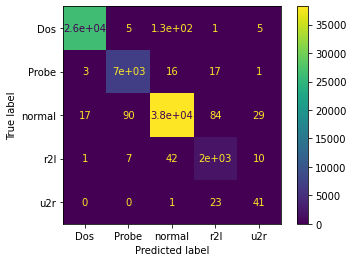

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'Dos' : 0,
               'Probe' : 1,
               'normal' : 2,
               'r2l' : 3,
               'u2r' : 4}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [22]:
print(cm)

[[26470     5   134     1     5]
 [    3  7021    16    17     1]
 [   17    90 38212    84    29]
 [    1     7    42  2028    10]
 [    0     0     1    23    41]]


In [23]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     26615
           1       0.99      0.99      0.99      7058
           2       0.99      0.99      0.99     38432
           3       0.94      0.97      0.96      2088
           4       0.48      0.63      0.54        65

    accuracy                           0.99     74258
   macro avg       0.88      0.92      0.90     74258
weighted avg       0.99      0.99      0.99     74258



In [24]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9934552506127285
Precision_weighted:  0.9936634299426905
Recall_weighted:  0.9934552506127285
mcc:  0.9889963005214285
f2:  0.9934968795000281
